<a href="https://colab.research.google.com/github/rajbircit/assignments/blob/main/dl_a2/aumentation_2nd_combination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

#### Show the environment

In [10]:
!nvidia-smi
print()
print()
print('=' * 80)
print()
print()
!df -h
print()
print()
print('=' * 80)
print()
print()
!free -m
print()
print()
print('=' * 80)
print()
print()
!lscpu
print()
print()
print('=' * 80)
print()
print()
! ps -eo pmem,pcpu,vsize,pid,cmd | sort -k 1 -nr | head -5


Fri Apr 30 12:15:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    72W / 149W |   4365MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Setup logging

In [11]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import logging
import sys
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
import shutil
import zipfile
import h5py
import gc
import IPython

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

#### Mount Google Drive And Copy Files

In [12]:
drive.mount('/content/gdrive')

if (os.path.exists("/root/imagedata")):
    ret = shutil.rmtree("/root/imagedata")
os.mkdir("/root/imagedata")
shutil.copyfile( \
    "/content/gdrive/MyDrive/DeepLearningAssignment2/earth_data.zip",
    "/root/imagedata/earth_data.zip")

!cd /root/imagedata && unzip earth_data.zip && rm -f earth_data.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  earth_data.zip
  inflating: earth_data.h5           


## Code to plot graphs and remember histories

In [13]:
class Entry:
    def __init__(self, loss, val_loss, accuracy, val_accuracy, best_accuracy, best_loss):
        self.loss = loss
        self.val_loss = val_loss
        self.accuracy = accuracy
        self.val_accuracy = val_accuracy
        self.best_accuracy = best_accuracy
        self.best_loss = best_loss

class Plot:
    def __init__(self):
        self.history = {}
        self.colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', \
                       'tab:orange', 'tab:green', 'tab:red', 'tab:purple', \
                       'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

    def plot_history(self, history, N_EPOCHS, name, show=True):
        if show:
            N_EPOCHS = len(history.history["loss"])
            plt.rcParams["figure.figsize"] = (20, 10)
            plt.xticks(np.arange(0, N_EPOCHS+1, 1.0))
            plt.plot(np.arange(0, N_EPOCHS), history.history["loss"], label="train loss", color='blue', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_loss"], label="val loss", color='blue', linestyle='dashdot')
            plt.plot(np.arange(0, N_EPOCHS), history.history["accuracy"], label="train acc", color='red', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_accuracy"], label="val acc", color='red', linestyle='dashdot')
            plt.legend()
            plt.show()
        best_val_acc = max(history.history['val_accuracy'])
        index_best_val_accuracy = history.history['val_accuracy'].index(best_val_acc)
        best_val_loss = min(history.history['val_loss'])
        index_best_val_loss = history.history['val_loss'].index(best_val_loss)
        if show:
            print(f"Best validation accuracy: {best_val_acc}, epoch = {index_best_val_accuracy}")
            print(f"Best validation loss: {best_val_loss}, epoch = {index_best_val_loss}")
        entry = Entry(\
                      loss=history.history["loss"],\
                      val_loss=history.history["val_loss"],\
                      accuracy=history.history["accuracy"],\
                      val_accuracy=history.history["val_accuracy"],\
                      best_accuracy=best_val_acc,
                      best_loss=best_val_loss)
        self.history[name] = entry
        gc.collect()

    def superplot(self):
        i = 0
        plt.rcParams["figure.figsize"] = [30, 10]
        fig, ax = plt.subplots(1, 2)
        def innerplot(self, ax, arr, text, linest):
            ax.plot(np.arange(0, len(arr)), arr, label=text, color=self.colors[i], linestyle=linest)
        for name, entry in self.history.items():
            innerplot(self, ax[0], entry.loss, f"{name}-loss", "solid")
            innerplot(self, ax[0], entry.val_loss, f"{name}-val-loss", "dashdot")
            innerplot(self, ax[1], entry.accuracy, f"{name}-accuracy", "solid")
            innerplot(self, ax[1], entry.val_accuracy, f"{name}-val-accuracy", "dashdot")
            i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()


    def superplot_contains_string(self, match):
        i = 0
        plt.rcParams["figure.figsize"] = [30, 10]
        fig, ax = plt.subplots(1, 2)
        def innerplot(self, ax, arr, text, linest):
            ax.plot(np.arange(0, len(arr)), arr, label=text, color=self.colors[i], linestyle=linest)
        for name, entry in self.history.items():
            if match.lower() in name.lower():
                innerplot(self, ax[0], entry.loss, f"{name}-loss", "solid")
                innerplot(self, ax[0], entry.val_loss, f"{name}-val-loss", "dashdot")
                innerplot(self, ax[1], entry.accuracy, f"{name}-accuracy", "solid")
                innerplot(self, ax[1], entry.val_accuracy, f"{name}-val-accuracy", "dashdot")
                i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()

    def superplot_notcontains_string(self, match):
        i = 0
        plt.rcParams["figure.figsize"] = [30, 10]
        fig, ax = plt.subplots(1, 2)
        def innerplot(self, ax, arr, text, linest):
            ax.plot(np.arange(0, len(arr)), arr, label=text, color=self.colors[i], linestyle=linest)
        for name, entry in self.history.items():
            if not (match.lower() in name.lower()):
                innerplot(self, ax[0], entry.loss, f"{name}-loss", "solid")
                innerplot(self, ax[0], entry.val_loss, f"{name}-val-loss", "dashdot")
                innerplot(self, ax[1], entry.accuracy, f"{name}-accuracy", "solid")
                innerplot(self, ax[1], entry.val_accuracy, f"{name}-val-accuracy", "dashdot")
                i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()




plot = Plot()
plot_adaptive = Plot()

## Extract train and test instances

In [14]:
def loadDataH5():
    with h5py.File('/root/imagedata/earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
        return trainX, trainY, valX, valY

trainX, trainY, valX, valY = loadDataH5()
trainX = trainX / 255.0
valX = valX / 255.0

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


## Callbacks

In [15]:
def decay_after_runs(N):
    NRUNS = N
    # We're sneaking this in, since this will be called at every epoch
    # it also gives us a good way to force calls to gc() within the fit function
    def learning_rate_scheduler(epoch, lr):
        gc.collect()
        if NRUNS < 0 or epoch < NRUNS:
            return lr
        else:
            print(f"Learning Rate: {lr} --> {lr * tf.math.exp(-1.0)}")
            return lr * tf.math.exp(-1.0)
    return learning_rate_scheduler
lr_callback = tf.keras.callbacks.LearningRateScheduler(decay_after_runs(20))

early_stopping = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=3,
                                                  verbose=1,
                                                  mode='auto')
early_stopping2 = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=10,
                                                  verbose=1,
                                                  mode='auto')


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(\
                                                 monitor='val_loss',\
                                                 factor=0.5,\
                                                 patience=3,\
                                                 min_lr=0.001)

term_on_nan = tf.keras.callbacks.TerminateOnNaN()

def get_checkpoint_callback(name):
    checkpoint_filepath = f"/content/gdrive/MyDrive/DeepLearningAssignment2/checkpoints-{name}-checkpoint"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    return model_checkpoint_callback


def get_callbacks_decay_after(N, name=None):
    if N == -2:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(-1)),
                        early_stopping2,
                        term_on_nan,
                        ]
    else:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(N)),
                        early_stopping,
                        term_on_nan,
                        ]
    if N > 0:
        callback_array.append(reduce_lr)
    if None != name:
        callback_array.append(get_checkpoint_callback(name))
    return callback_array

# Question 1 Part A

## 1. Build a Baseline

In [16]:
tf.random.set_seed(5)
plot2 = Plot()
n_classes = len(np.unique(np.concatenate((trainY, valY))))

N_EPOCHS=100


## 4. 2 Conv 2 Dense Layers

(64, 64, 3) 9


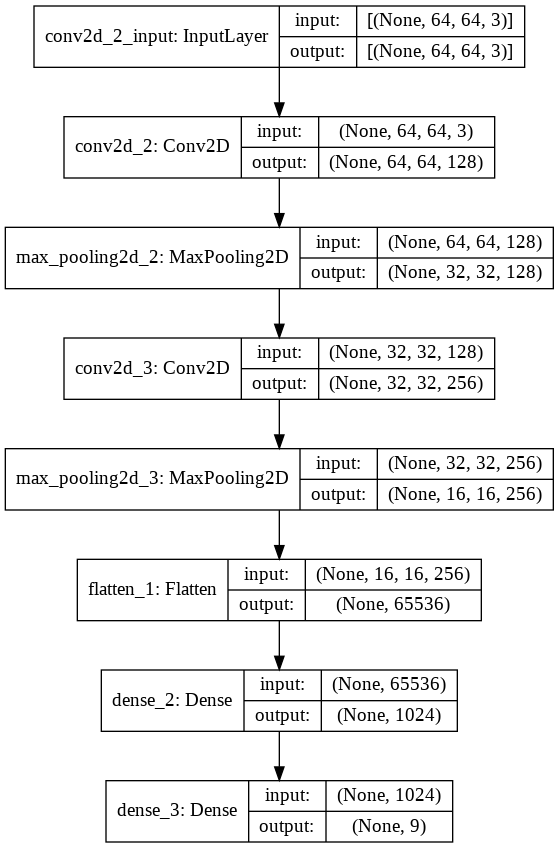

Model: "BaseLineTwoConvTwoDenseLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              67109888  
_________________________________________________________________
dense_3 (Dense)              (None, 9

In [17]:
tf.random.set_seed(5)
class BaselineTwoConvTwoDenseLayers:
    @staticmethod
    def build(inshape, nlabels):
        print(inshape, nlabels)
        inputShape = trainX[0].shape
        model = tf.keras.Sequential(name="BaseLineTwoConvTwoDenseLayers")
        model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', \
                  input_shape=inshape, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', \
                                         activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(1024, activation='relu'))
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        plot = tf.keras.utils.plot_model(model, show_shapes=True, \
                                         expand_nested=True)
        IPython.display.display(plot)
        print(model.summary())
        return model

n_classes = len(np.unique(np.concatenate((trainY, valY))))

model = BaselineTwoConvTwoDenseLayers.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=get_callbacks_decay_after(-1, model.name))

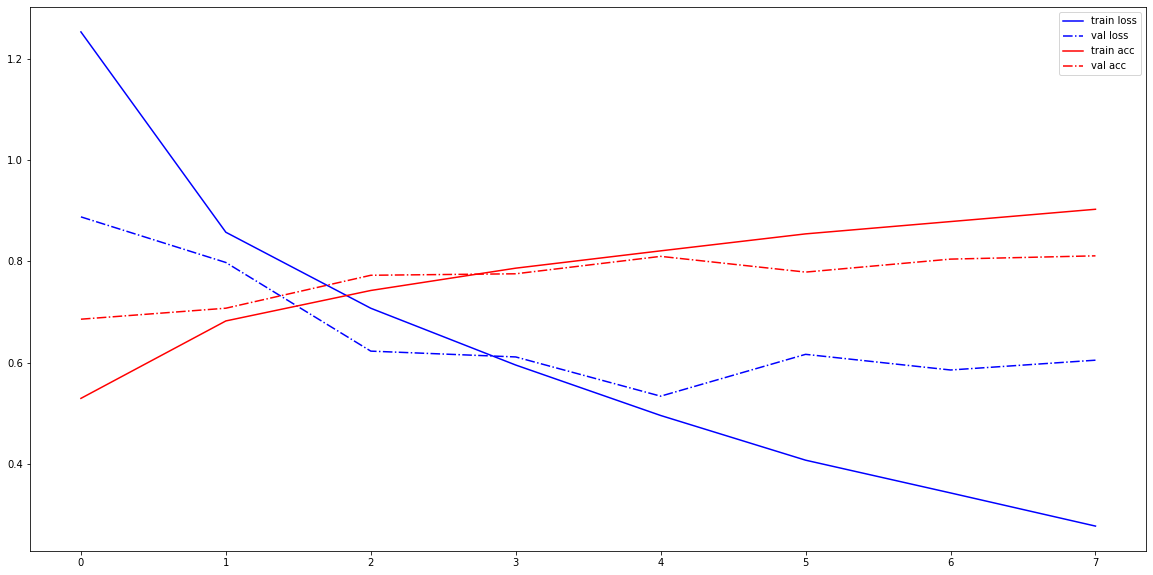

Best validation accuracy: 0.8108333349227905, epoch = 7
Best validation loss: 0.5339582562446594, epoch = 4


In [18]:
plot.plot_history(history, N_EPOCHS, model.name)
plot2 = Plot()
plot2.plot_history(history, N_EPOCHS, model.name, show=False)

# Experiment with Data Augmentation

(64, 64, 3) 9


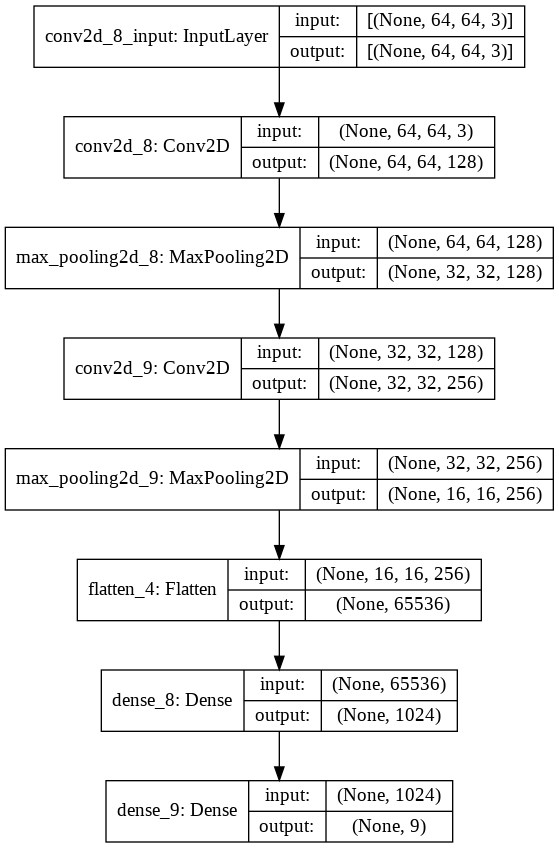

Model: "BaseLineTwoConvTwoDenseLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              67109888  
_________________________________________________________________
dense_9 (Dense)              (None, 9

In [22]:
train_aug = tf.keras.preprocessing.image.ImageDataGenerator(\
                                                      rotation_range=20,\
                                                      width_shift_range=0.1,\
                                                      shear_range=0.2,\
                                                      zoom_range=0.4,\
                                                      horizontal_flip=True)
train_generator = train_aug.flow(trainX, trainY, batch_size=32, seed=7)


"""
val_aug = tf.keras.preprocessing.image.ImageDataGenerator(\
                                                      rotation_range=20,\
                                                      width_shift_range=0.1,\
                                                      shear_range=0.2,\
                                                      zoom_range=0.4,\
                                                      horizontal_flip=True)
val_generator = val_aug.flow(valX, valY, batch_size=32, seed=7)
"""

N_EPOCHS=50

tf.random.set_seed(5)
model = BaselineTwoConvTwoDenseLayers.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
"""
history = model.fit(\
                    train_generator,
                    steps_per_epoch=trainX.shape[0]//32,
                    epochs=N_EPOCHS,
                    validation_data=val_generator,
                    validation_steps=valX.shape[0] // 32)
"""
history = model.fit(\
                    train_generator,
                    steps_per_epoch=trainX.shape[0]//32,
                    epochs=N_EPOCHS,
                    validation_data=(valX, valY),
                    callbacks=get_callbacks_decay_after(-2, model.name))


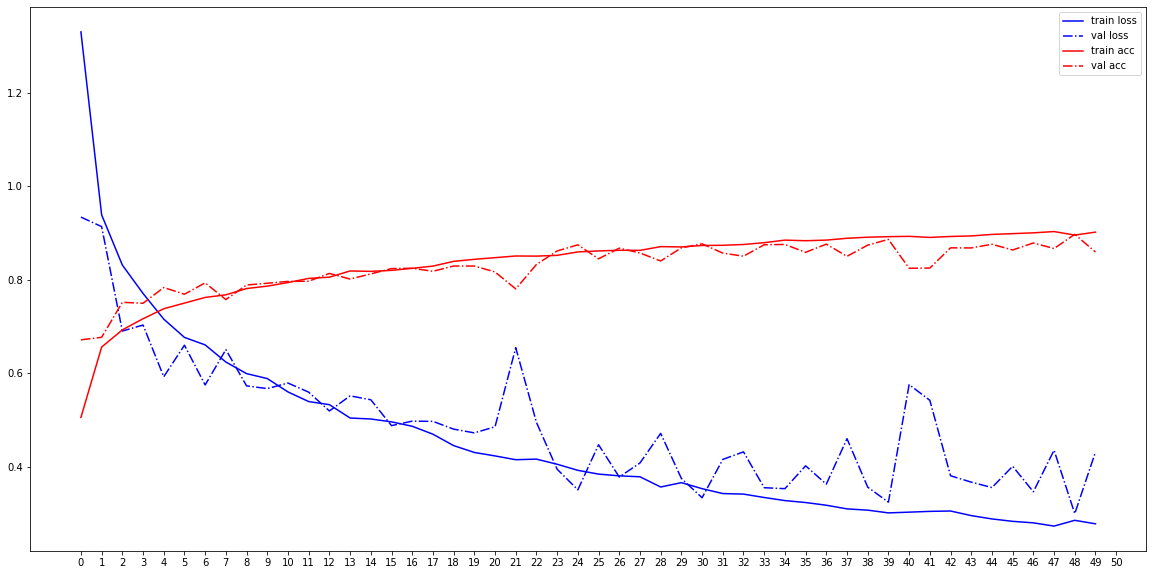

Best validation accuracy: 0.8974999785423279, epoch = 48
Best validation loss: 0.29912006855010986, epoch = 48


In [23]:
plot.plot_history(history, N_EPOCHS, f"{model.name}-augmented1")


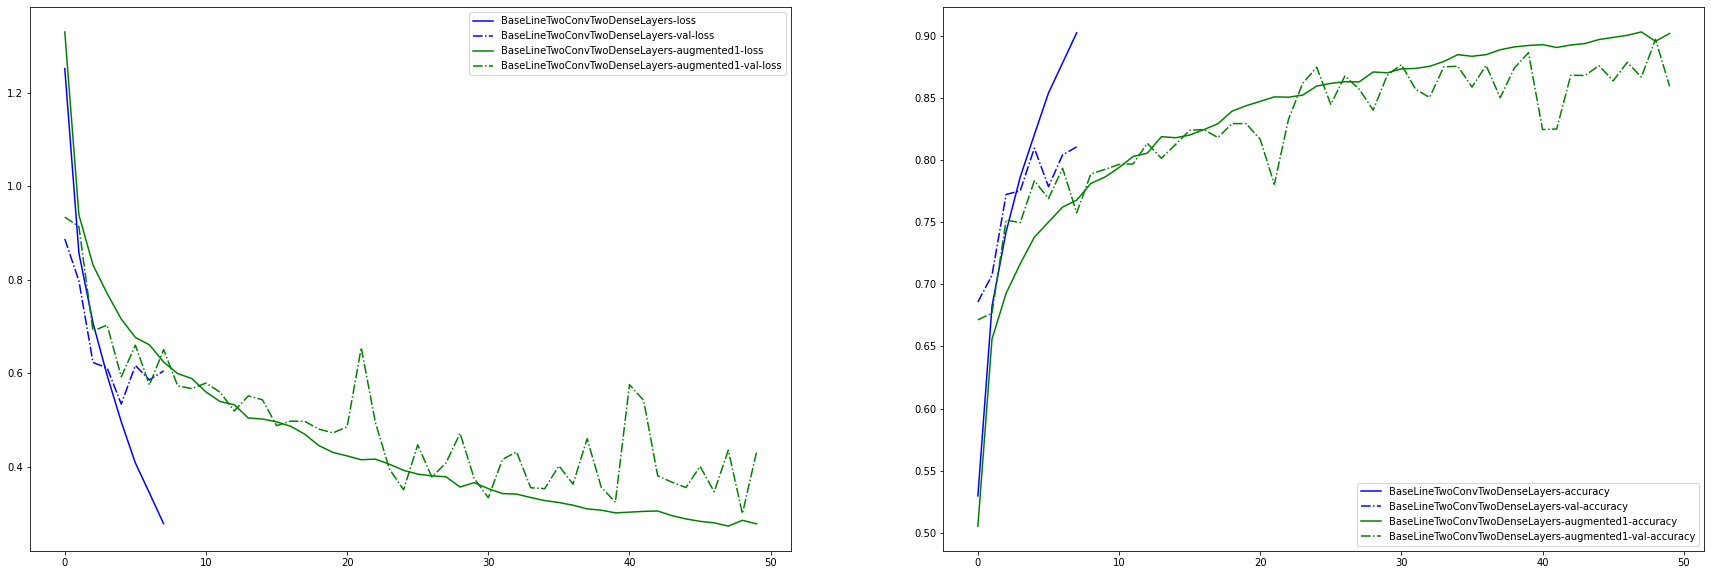

In [24]:
plot.superplot()

# Different Data Augmentation scheme

(64, 64, 3) 9


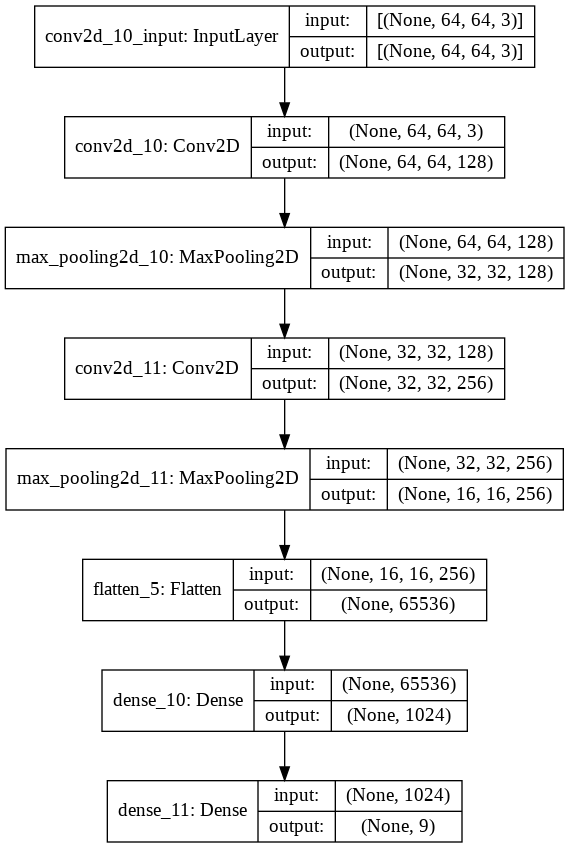

Model: "BaseLineTwoConvTwoDenseLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              67109888  
_________________________________________________________________
dense_11 (Dense)             (None, 9

In [ ]:
"""
train_aug2 = tf.keras.preprocessing.image.ImageDataGenerator(\
                                                      rotation_range=40,\
                                                      brightness_range=(0.85, 1.,),\
                                                      zoom_range=0.5,\
                                                      horizontal_flip=True,\
                                                      vertical_flip=True)
"""
train_aug2 = tf.keras.preprocessing.image.ImageDataGenerator(\
                                                      rotation_range=30,\
                                                      width_shift_range=0.1,\
                                                      height_shift_range=0.2,\
                                                      zoom_range=0.4,\
                                                      vertical_flip=2,\
                                                      horizontal_flip=True)
train_generator = train_aug2.flow(trainX, trainY, batch_size=32, seed=7)


N_EPOCHS=50

tf.random.set_seed(5)

model2 = BaselineTwoConvTwoDenseLayers.build(tuple(trainX[0].shape), n_classes)
model2.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model2.fit(\
                    train_generator,
                    steps_per_epoch=trainX.shape[0]//32,
                    epochs=N_EPOCHS,
                    validation_data=(valX, valY),
                    callbacks=get_callbacks_decay_after(-2, model2.name))
plot.plot_history(history, N_EPOCHS, f"{model2.name}-augmented2")
plot.superplot()

In [ ]:
"""
train_aug2 = tf.keras.preprocessing.image.ImageDataGenerator(\
                                                      rotation_range=40,\
                                                      brightness_range=(0.85, 1.,),\
                                                      zoom_range=0.5,\
                                                      horizontal_flip=True,\
                                                      vertical_flip=True)
"""
train_aug2 = tf.keras.preprocessing.image.ImageDataGenerator(\
                                                      rotation_range=30,\
                                                      brightness_range=(0.80, 1.2,),\
                                                      width_shift_range=0.1,\
                                                      height_shift_range=0.2,\
                                                      zoom_range=0.4,\
                                                      vertical_flip=2,\
                                                      horizontal_flip=True)
train_generator = train_aug2.flow(trainX, trainY, batch_size=32, seed=7)


N_EPOCHS=50

tf.random.set_seed(5)
model2 = BaselineTwoConvTwoDenseLayers.build(tuple(trainX[0].shape), n_classes)
model2.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model2.fit(\
                    train_generator,
                    steps_per_epoch=trainX.shape[0]//32,
                    epochs=N_EPOCHS,
                    validation_data=(valX, valY),
                    callbacks=get_callbacks_decay_after(-2, model2.name))
plot.plot_history(history, N_EPOCHS, f"{model2.name}-augmented-3")
plot.superplot()

In [ ]:
train_aug = tf.keras.preprocessing.image.ImageDataGenerator(\
                                                      rotation_range=20,\
                                                      horizontal_flip=True)
train_generator = train_aug.flow(trainX, trainY, batch_size=32, seed=7)



N_EPOCHS=50

tf.random.set_seed(5)
model = BaselineTwoConvTwoDenseLayers.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)

history = model.fit(\
                    train_generator,
                    steps_per_epoch=trainX.shape[0]//32,
                    epochs=N_EPOCHS,
                    validation_data=(valX, valY),
                    callbacks=get_callbacks_decay_after(-2, model.name))

plot.plot_history(history, N_EPOCHS, f"{model.name}-augmented-4")
plot.superplot()
plot.superplot_contains_string('augment')


In [ ]:
plot.plot_history(history, N_EPOCHS, f"{model.name}-augmented-4")
plot.superplot()
plot.superplot_contains_string('augment')
plot.superplot_notcontains_string('augmented-3')


In [ ]:
import pandas as pd
import seaborn as sns

def compare_best_accuracies():
    data_to_plot = {}
    for name, entry in plot.history.items():
        print(name, max(entry.val_accuracy))
        data_to_plot[name] = max(entry.val_accuracy)
    for name, entry in plot_adaptive.history.items():
        data_to_plot[name] = max(entry.val_accuracy)
        print(name, max(entry.val_accuracy))
    import seaborn as sns
    import pandas as pd
    df = pd.DataFrame(
        {
            "Model": pd.Series(data_to_plot.keys()),
            "Accuracy": pd.Series(data_to_plot.values())
        }
    )
    sns.barplot(y='Model', x='Accuracy', data=df.sort_values('Accuracy'), orient='h')
    plt.show()

In [ ]:

compare_best_accuracies()